In [1]:
!pip install -q adversarial-robustness-toolbox

c:\Users\aashu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\aashu\AppData\Local\Programs\Python\Python39\lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


[INFO] TensorFlow version: 2.20.0
[INFO] Images will be saved under: C:\Users\aashu\Desktop\ass sec\secure_ai_outputs\images
[INFO] Models will be saved under: C:\Users\aashu\Desktop\ass sec\secure_ai_outputs\models

STEP 1: Load MNIST and train baseline CNN on CLEAN data
[INFO] Raw shapes – x_train: (60000, 28, 28), x_test: (10000, 28, 28)
[INFO] Input shape: (28, 28, 1)
Epoch 1/3
422/422 - 17s - 41ms/step - accuracy: 0.9252 - loss: 0.2439 - val_accuracy: 0.9832 - val_loss: 0.0571
Epoch 2/3
422/422 - 15s - 36ms/step - accuracy: 0.9787 - loss: 0.0696 - val_accuracy: 0.9882 - val_loss: 0.0442
Epoch 3/3
422/422 - 16s - 38ms/step - accuracy: 0.9842 - loss: 0.0500 - val_accuracy: 0.9888 - val_loss: 0.0435
[SAVED] Baseline CNN model -> secure_ai_outputs\models\cnn_mnist_baseline.keras

STEP 2: Data Poisoning – Method 1 (corner-square trigger)
[INFO] Created poisoned TRAIN subset of size 100 for digit 7
[INFO] Created triggered TEST set with corner-square on every image


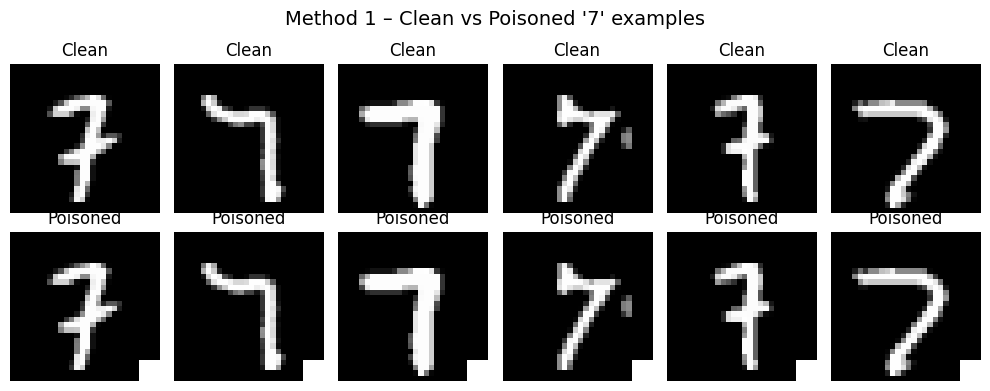

[SAVED] Poison examples figure -> secure_ai_outputs\images\method1_poison_examples.png

STEP 3: Data Poisoning – Method 2 (FGSM via ART)
[INFO] FGSM adversarial TRAIN set generated in 80.38s
[INFO] FGSM adversarial TEST set generated in 7.97s


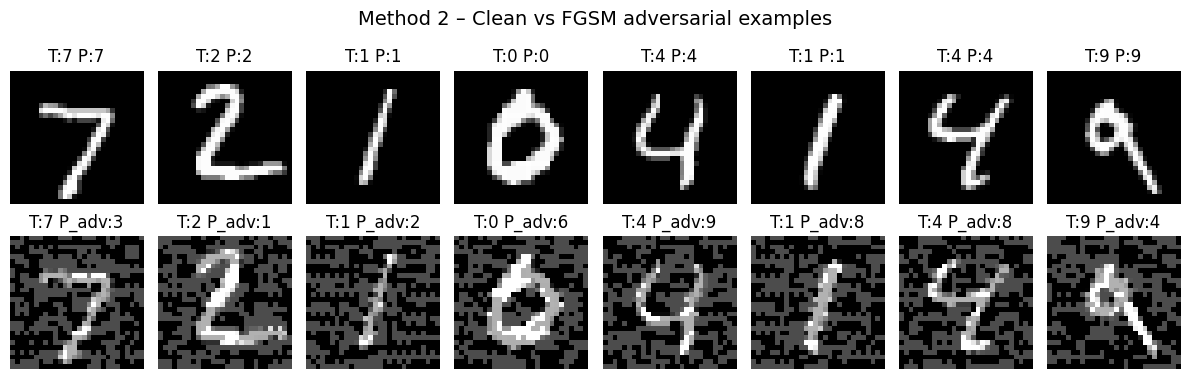

[SAVED] Clean vs FGSM figure -> secure_ai_outputs\images\method2_clean_vs_fgsm.png

STEP 4: Evaluate baseline CNN on clean, triggered, FGSM test data

[METRICS] Baseline CNN on CLEAN test set
[RESULT] Baseline – clean test: loss=0.0336, acc=98.79%, inference_time=1.450s (0.145 ms/sample)


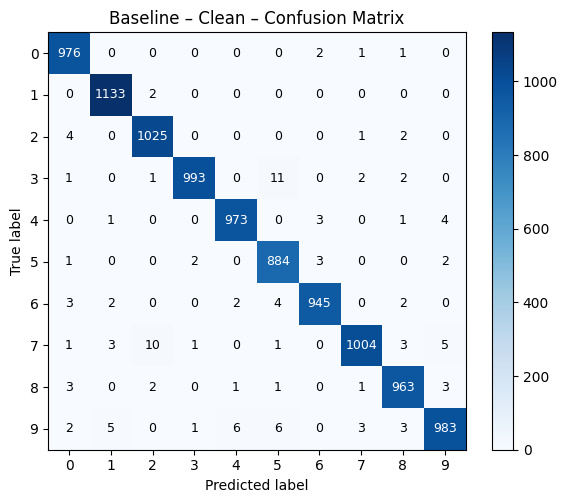

[SAVED] Confusion matrix -> secure_ai_outputs\images\baseline_confusion_clean.png

[METRICS] Baseline CNN on TRIGGERED test set (Method 1)
[RESULT] Baseline – triggered test: loss=0.0798, acc=97.42%, inference_time=1.418s (0.142 ms/sample)


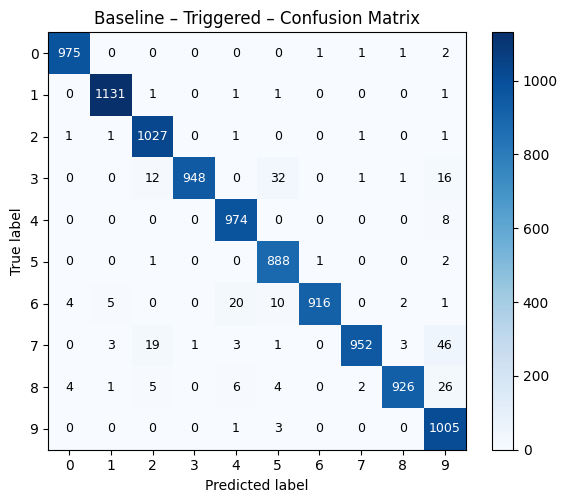

[SAVED] Confusion matrix -> secure_ai_outputs\images\baseline_confusion_triggered.png

[METRICS] Baseline CNN on FGSM ADVERSARIAL test set (Method 2)
[RESULT] Baseline – FGSM test: loss=3.4481, acc=13.54%, inference_time=1.372s (0.137 ms/sample)


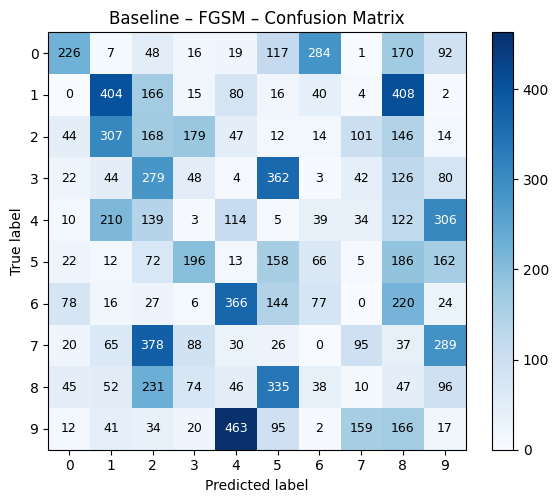

[SAVED] Confusion matrix -> secure_ai_outputs\images\baseline_confusion_fgsm.png

STEP 5: Protection / Blue Teaming – FGSM adversarial training (Task 7)
[INFO] Mixed training set shape: (120000, 28, 28, 1)
Epoch 1/3
844/844 - 32s - 37ms/step - accuracy: 0.9310 - loss: 0.2305 - val_accuracy: 0.9822 - val_loss: 0.0661
Epoch 2/3
844/844 - 30s - 36ms/step - accuracy: 0.9808 - loss: 0.0718 - val_accuracy: 0.9883 - val_loss: 0.0446
Epoch 3/3
844/844 - 30s - 35ms/step - accuracy: 0.9859 - loss: 0.0509 - val_accuracy: 0.9903 - val_loss: 0.0368
[SAVED] Defense CNN model -> secure_ai_outputs\models\cnn_mnist_defense_fgsm.keras

[METRICS] Defense CNN on CLEAN test set
[RESULT] Defense – clean test: loss=0.0324, acc=98.93%, inference_time=1.480s (0.148 ms/sample)


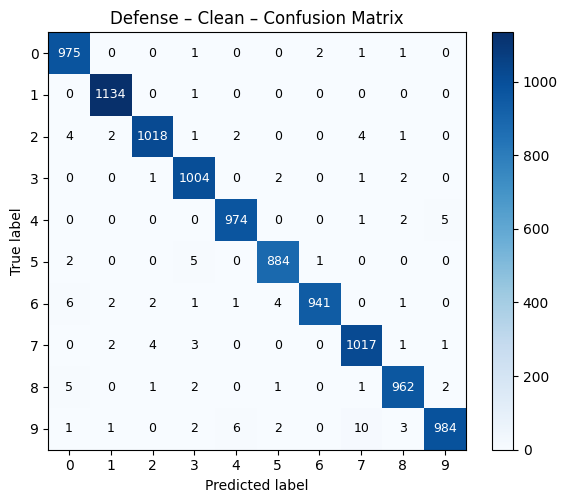

[SAVED] Confusion matrix -> secure_ai_outputs\images\defense_confusion_clean.png

[METRICS] Defense CNN on FGSM test set
[RESULT] Defense – FGSM test: loss=0.0561, acc=98.67%, inference_time=1.416s (0.142 ms/sample)


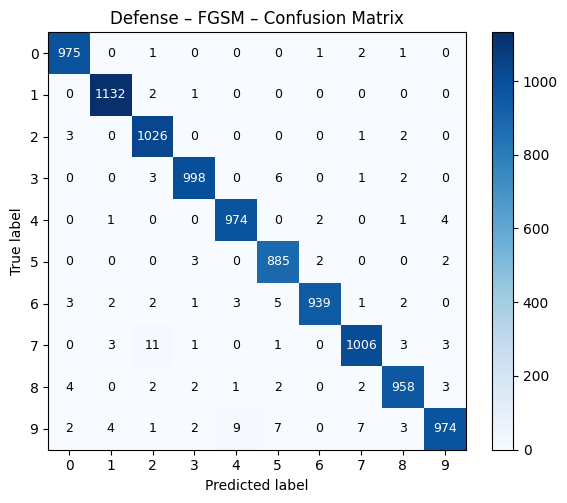

[SAVED] Confusion matrix -> secure_ai_outputs\images\defense_confusion_fgsm.png

STEP 6: JSON summary of metrics (accuracy, loss, confmatrix, inference)
[SUMMARY JSON]
{
  "clean_test": {
    "loss": 0.0335761234164238,
    "accuracy": 0.9879000186920166,
    "inference_time_s": 1.4495115280151367,
    "inference_time_per_sample_ms": 0.14495115280151366
  },
  "triggered_test_method1": {
    "loss": 0.07981555908918381,
    "accuracy": 0.9742000102996826,
    "inference_time_s": 1.4183366298675537,
    "inference_time_per_sample_ms": 0.14183366298675537
  },
  "fgsm_test_method2": {
    "loss": 3.448099136352539,
    "accuracy": 0.13539999723434448,
    "inference_time_s": 1.3718445301055908,
    "inference_time_per_sample_ms": 0.13718445301055907
  },
  "defense_fgsm": {
    "clean_test": {
      "loss": 0.03242556378245354,
      "accuracy": 0.989300012588501,
      "inference_time_s": 1.479858160018921,
      "inference_time_per_sample_ms": 0.1479858160018921
    },
    "fgsm_test":

In [2]:

import time
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

# ------------------------------------------------------------------
# Global setup
# ------------------------------------------------------------------
pd.set_option("display.max_colwidth", None)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"[INFO] TensorFlow version: {tf.__version__}")

# Output folders
BASE_OUT   = Path("secure_ai_outputs")
IMG_DIR    = BASE_OUT / "images"
MODEL_DIR  = BASE_OUT / "models"
for d in [IMG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Images will be saved under: {IMG_DIR.resolve()}")
print(f"[INFO] Models will be saved under: {MODEL_DIR.resolve()}")

# ------------------------------------------------------------------
# Helper: simple CNN for MNIST
# ------------------------------------------------------------------
def build_cnn(input_shape=(28, 28, 1), num_classes=10) -> tf.keras.Model:
    model = models.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# ------------------------------------------------------------------
# Plot helpers
# ------------------------------------------------------------------
def plot_and_save_poison_examples(x_clean, x_poisoned, poison_indices, out_path, n_show=6):
    plt.figure(figsize=(10, 4))
    n_show = min(n_show, len(poison_indices))
    for i in range(n_show):
        idx = poison_indices[i]
        # clean
        plt.subplot(2, n_show, i + 1)
        plt.imshow(x_clean[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("Clean")
        # poisoned
        plt.subplot(2, n_show, i + 1 + n_show)
        plt.imshow(x_poisoned[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("Poisoned")
    plt.suptitle("Method 1 – Clean vs Poisoned '7' examples", fontsize=14)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"[SAVED] Poison examples figure -> {out_path}")

def plot_and_save_clean_vs_adv(x_clean, x_adv, y_true, y_clean_pred, y_adv_pred, out_path, n=8):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        idx = i
        # clean
        plt.subplot(2, n, i + 1)
        plt.imshow(x_clean[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"T:{y_true[idx]} P:{y_clean_pred[idx]}")
        # adv
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_adv[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"T:{y_true[idx]} P_adv:{y_adv_pred[idx]}")
    plt.suptitle("Method 2 – Clean vs FGSM adversarial examples", fontsize=14)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"[SAVED] Clean vs FGSM figure -> {out_path}")

def plot_and_save_confusion_matrix(cm, title, out_path):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    # ---- NEW: draw numbers inside each cell ----
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                str(cm[i, j]),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=9,
            )

    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"[SAVED] Confusion matrix -> {out_path}")

# ------------------------------------------------------------------
# Generic evaluation: ONLY loss, accuracy, inference time, confusion
# ------------------------------------------------------------------
def evaluate_model_with_metrics(model, x, y_true_cat, y_true_labels,
                                label_prefix, cm_title_prefix, cm_filename):
    """
    Returns (loss, acc, total_inf_time, time_per_sample, confusion_matrix)
    """
    # Inference time (evaluate includes forward + metric computation)
    t0 = time.time()
    loss, acc = model.evaluate(x, y_true_cat, verbose=0)
    total_time = time.time() - t0
    per_sample = total_time / len(x)

    # Confusion matrix (predict separately; not part of timed block)
    y_pred_probs = model.predict(x, verbose=0)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    print(
        f"[RESULT] {label_prefix}: "
        f"loss={loss:.4f}, acc={acc*100:.2f}%, "
        f"inference_time={total_time:.3f}s "
        f"({per_sample*1000:.3f} ms/sample)"
    )

    # Directly plot the confusion matrix with numbers inside
    out_path = IMG_DIR / cm_filename
    plot_and_save_confusion_matrix(cm, f"{cm_title_prefix} – Confusion Matrix", out_path)

    return loss, acc, total_time, per_sample, cm

# ------------------------------------------------------------------
# STEP 1: Load MNIST and train baseline CNN on CLEAN data
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 1: Load MNIST and train baseline CNN on CLEAN data")
print("="*70)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"[INFO] Raw shapes – x_train: {x_train.shape}, x_test: {x_test.shape}")

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)
input_shape = x_train.shape[1:]
print(f"[INFO] Input shape: {input_shape}")

baseline_model = build_cnn(input_shape, num_classes)

EPOCHS = 3    # keep small for speed
BATCH  = 128

baseline_model.fit(
    x_train, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.1,
    verbose=2,
)

# Save model
baseline_path = MODEL_DIR / "cnn_mnist_baseline.keras"
baseline_model.save(baseline_path)
print(f"[SAVED] Baseline CNN model -> {baseline_path}")

# ------------------------------------------------------------------
# STEP 2: Data Poisoning – Method 1 (poisoned dataset + triggered test)
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 2: Data Poisoning – Method 1 (corner-square trigger)")
print("="*70)

def add_corner_square_trigger(
    images: np.ndarray,
    size: int = 4,
    intensity: float = 1.0,
    position: str = "bottom_right",
) -> np.ndarray:
    """
    Add a small square trigger to all given images.
    images   : (N, 28, 28, 1) in [0,1]
    size     : side length of square
    intensity: pixel value (1.0 = white)
    position : one of {'top_left','top_right','bottom_left','bottom_right'}
    """
    poisoned = images.copy()
    h, w = poisoned.shape[1], poisoned.shape[2]
    s = size

    if position == "top_left":
        r_slice, c_slice = slice(0, s), slice(0, s)
    elif position == "top_right":
        r_slice, c_slice = slice(0, s), slice(w - s, w)
    elif position == "bottom_left":
        r_slice, c_slice = slice(h - s, h), slice(0, s)
    elif position == "bottom_right":
        r_slice, c_slice = slice(h - s, h), slice(w - s, w)
    else:
        raise ValueError("Bad position for trigger")

    poisoned[:, r_slice, c_slice, :] = intensity
    return poisoned

TARGET_DIGIT = 7
NUM_POISON   = 100
TRIGGER_SIZE = 4
TRIGGER_POS  = "bottom_right"

digit_idxs = np.where(y_train == TARGET_DIGIT)[0]
np.random.seed(SEED)
poison_idxs = np.random.choice(digit_idxs, size=NUM_POISON, replace=False)

# Poisoned training subset (for report; we don't retrain in this minimal version)
x_train_poisoned_subset = add_corner_square_trigger(
    x_train[poison_idxs],
    size=TRIGGER_SIZE,
    intensity=1.0,
    position=TRIGGER_POS,
)
print(f"[INFO] Created poisoned TRAIN subset of size {len(poison_idxs)} for digit {TARGET_DIGIT}")

# Triggered TEST set (new test data for Method 1)
x_test_triggered = add_corner_square_trigger(
    x_test.copy(),
    size=TRIGGER_SIZE,
    intensity=1.0,
    position=TRIGGER_POS,
)
print("[INFO] Created triggered TEST set with corner-square on every image")

# Save example images clean vs poisoned
poison_fig_path = IMG_DIR / "method1_poison_examples.png"
plot_and_save_poison_examples(
    x_train[poison_idxs],          # clean subset
    x_train_poisoned_subset,       # poisoned subset
    list(range(len(poison_idxs))),
    poison_fig_path,
)

# ------------------------------------------------------------------
# STEP 3: Data Poisoning – Method 2 (FGSM adversarial samples via ART)
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 3: Data Poisoning – Method 2 (FGSM via ART)")
print("="*70)

classifier = KerasClassifier(
    model=baseline_model,
    clip_values=(0.0, 1.0),
    use_logits=False,
)

fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.3,
    batch_size=128,
)

# FGSM adversarial TRAIN set (for Task 7)
t0 = time.time()
x_train_adv = fgsm.generate(x=x_train)
print(f"[INFO] FGSM adversarial TRAIN set generated in {time.time()-t0:.2f}s")

# FGSM adversarial TEST set (new test data for Method 2)
t0 = time.time()
x_test_adv = fgsm.generate(x=x_test)
print(f"[INFO] FGSM adversarial TEST set generated in {time.time()-t0:.2f}s")

# Save a side-by-side figure for report
y_clean_pred = np.argmax(baseline_model.predict(x_test, verbose=0), axis=1)
y_adv_pred   = np.argmax(baseline_model.predict(x_test_adv, verbose=0), axis=1)
fgsm_fig_path = IMG_DIR / "method2_clean_vs_fgsm.png"
plot_and_save_clean_vs_adv(
    x_test, x_test_adv, y_test, y_clean_pred, y_adv_pred, fgsm_fig_path
)

# ------------------------------------------------------------------
# STEP 4: Evaluate CNN on clean / triggered / FGSM test data (Task 6)
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 4: Evaluate baseline CNN on clean, triggered, FGSM test data")
print("="*70)

# 4a) Clean test
print("\n[METRICS] Baseline CNN on CLEAN test set")
(
    loss_clean,
    acc_clean,
    t_clean,
    t_clean_per_sample,
    cm_clean,
) = evaluate_model_with_metrics(
    baseline_model,
    x_test,
    y_test_cat,
    y_test,
    label_prefix="Baseline – clean test",
    cm_title_prefix="Baseline – Clean",
    cm_filename="baseline_confusion_clean.png",
)

# 4b) Triggered test (Method 1 new test)
print("\n[METRICS] Baseline CNN on TRIGGERED test set (Method 1)")
(
    loss_trigger,
    acc_trigger,
    t_trigger,
    t_trigger_per_sample,
    cm_trigger,
) = evaluate_model_with_metrics(
    baseline_model,
    x_test_triggered,
    y_test_cat,
    y_test,
    label_prefix="Baseline – triggered test",
    cm_title_prefix="Baseline – Triggered",
    cm_filename="baseline_confusion_triggered.png",
)

# 4c) FGSM adversarial test (Method 2 new test)
print("\n[METRICS] Baseline CNN on FGSM ADVERSARIAL test set (Method 2)")
(
    loss_fgsm,
    acc_fgsm,
    t_fgsm,
    t_fgsm_per_sample,
    cm_fgsm,
) = evaluate_model_with_metrics(
    baseline_model,
    x_test_adv,
    y_test_cat,
    y_test,
    label_prefix="Baseline – FGSM test",
    cm_title_prefix="Baseline – FGSM",
    cm_filename="baseline_confusion_fgsm.png",
)

# ------------------------------------------------------------------
# STEP 5: Task 7 – Protection / Blue Teaming (train with clean + FGSM)
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 5: Protection / Blue Teaming – FGSM adversarial training (Task 7)")
print("="*70)

# Mix clean and FGSM adversarial training examples (50/50)
x_train_mixed = np.concatenate([x_train, x_train_adv], axis=0)
y_train_mixed = np.concatenate([y_train_cat, y_train_cat], axis=0)

# Shuffle
perm = np.random.permutation(len(x_train_mixed))
x_train_mixed = x_train_mixed[perm]
y_train_mixed = y_train_mixed[perm]

print(f"[INFO] Mixed training set shape: {x_train_mixed.shape}")

# New model trained on mixed (clean + FGSM) data
defense_model = build_cnn(input_shape, num_classes)

EPOCHS_DEF = 3
BATCH_DEF  = 128

defense_model.fit(
    x_train_mixed,
    y_train_mixed,
    epochs=EPOCHS_DEF,
    batch_size=BATCH_DEF,
    validation_split=0.1,
    verbose=2,
)

defense_path = MODEL_DIR / "cnn_mnist_defense_fgsm.keras"
defense_model.save(defense_path)
print(f"[SAVED] Defense CNN model -> {defense_path}")

# Evaluate defense model on CLEAN and FGSM test sets
print("\n[METRICS] Defense CNN on CLEAN test set")
(
    loss_def_clean,
    acc_def_clean,
    t_def_clean,
    t_def_clean_per_sample,
    cm_def_clean,
) = evaluate_model_with_metrics(
    defense_model,
    x_test,
    y_test_cat,
    y_test,
    label_prefix="Defense – clean test",
    cm_title_prefix="Defense – Clean",
    cm_filename="defense_confusion_clean.png",
)

print("\n[METRICS] Defense CNN on FGSM test set")
(
    loss_def_fgsm,
    acc_def_fgsm,
    t_def_fgsm,
    t_def_fgsm_per_sample,
    cm_def_fgsm,
) = evaluate_model_with_metrics(
    defense_model,
    x_test_adv,
    y_test_cat,
    y_test,
    label_prefix="Defense – FGSM test",
    cm_title_prefix="Defense – FGSM",
    cm_filename="defense_confusion_fgsm.png",
)

# ------------------------------------------------------------------
# STEP 6: Final JSON summary – ONLY required metrics
# ------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 6: JSON summary of metrics (accuracy, loss, confmatrix, inference)")
print("="*70)

summary = {
    "clean_test": {
        "loss": float(loss_clean),
        "accuracy": float(acc_clean),
        "inference_time_s": float(t_clean),
        "inference_time_per_sample_ms": float(t_clean_per_sample * 1000),
        
    },
    "triggered_test_method1": {
        "loss": float(loss_trigger),
        "accuracy": float(acc_trigger),
        "inference_time_s": float(t_trigger),
        "inference_time_per_sample_ms": float(t_trigger_per_sample * 1000),
        
    },
    "fgsm_test_method2": {
        "loss": float(loss_fgsm),
        "accuracy": float(acc_fgsm),
        "inference_time_s": float(t_fgsm),
        "inference_time_per_sample_ms": float(t_fgsm_per_sample * 1000),
        
    },
    "defense_fgsm": {
        "clean_test": {
            "loss": float(loss_def_clean),
            "accuracy": float(acc_def_clean),
            "inference_time_s": float(t_def_clean),
            "inference_time_per_sample_ms": float(t_def_clean_per_sample * 1000),
            
        },
        "fgsm_test": {
            "loss": float(loss_def_fgsm),
            "accuracy": float(acc_def_fgsm),
            "inference_time_s": float(t_def_fgsm),
            "inference_time_per_sample_ms": float(t_def_fgsm_per_sample * 1000),
            
        },
    },
}

summary_path = BASE_OUT / "metrics_summary_tasks5_6_7.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("[SUMMARY JSON]")
print(json.dumps(summary, indent=2))
print(f"\n[SAVED] Metrics summary JSON -> {summary_path.resolve()}")

